In [1]:
import sys
sys.path.append('./')
import DataGen
import technical_indicators as ti
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from strategy_test import strategy_test
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from itertools import compress
import json
import joblib
import utils
import ml_model as ml
import warnings

This notebook provide an interface of leveraging machine learning to come up with a smarter strategy which combines multiple technique indicators to predict when to buy in crypto currencies.I picked some of the best performing technique indicators of each investing style catogories.<br/>
1. Volume indicators:<br/>
*OBV - On Balance Volume<br/>
2. Overlap indicators:<br/>
*BBANDS - Bollinger Bands<br/>
*SMA - Simple Moving Average<br/>
3. Momentum_indicators:<br/>
*ADXR - Average Directional Movement Index Rating<br/>
*RSI - Relative Strength Index<br/>
*STOCH - Stochastic Oscillator Slow<br/>
4. Volatility indicators:<br/>
*NATR - Normalized Average True Range<br/>
5. Statistic indicators:<br/>
*BETA - Beta<br/>
*LINEARREG_ANGLE - Linear Regression Angle<br/>
*STDDEV - Standard Deviation<br/>
6. Cycle_indicators:<br/>
*HT_TRENDMODE- Hilbert Transform - Trend vs Cycle Mode<br/>
*HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period<br/>
*HT_SINE - Hilbert Transform - SineWave<br/>
*HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase<br/>

In [2]:
dg=DataGen.DataGen('Gemini','BTC','D')
dg.load()

First, load data. The user can specify the source, name for the crypto currency and the data frequency.<br/>
'D' for daily data. 'H' for hourly data.

In [3]:
windowsizes=[int(x) for x in np.linspace(1,90,90)]
responses=dg.get_leading_log_rt(windowsizes)
responses.dropna(inplace=True)

Next, I calculate the leading log returns for different window sizes (1day to 90days) as the responses for the model to predict.<br/>
The user can choose different investment horizons, as short as 1 day and as long as 90 days (of course it can be easily extended by changing the numbers in the above cell).<br/>
The programm will try to predict the return given the investment horizon. If it is greater than certain threshold, then it will buy crypto currency and sell it at the end of the investment horizon. We want the threshold to be at least greater than the transaction cost which I assume 1% for single transaction and 2% for one investment period (buy at the beginning and sell at the end). The investment is carrying on rolling windows.<br/>
Here I used log returns because it is more close to a normal distribution (see the explotory analysis in other notebooks) than other forms of return and easy to calculate the average returns.

In [4]:
data=dg.get_data()
tid=ti.technical_indicators(data)

Then I creates a technical indicators class object as an interface to calculates technical indicators as user specified. In this notebook, I explored combinations of them. But one can easily change it by alternating the parameters of the function **tid.get_composite_idts()** as below.

In [5]:
window=15
tech=tid.get_composite_idts(ml.ml_config(window))
tech.dropna(inplace=True)
start=max(tech.index.min(),responses.index.min())
end=min(tech.index.max(),responses.index.max())
target='log_rt_'+str(window)
X=tech.loc[start:end,:]
Y=responses.loc[start:end,[target]]

Here the only parameters the user need to specify here is the investment horizon. The program will automatically pick a handful of technique indicators based on that. One can plot out a correlation heatmap to have a quick look at the dependences of responses and the technique indicators generated.

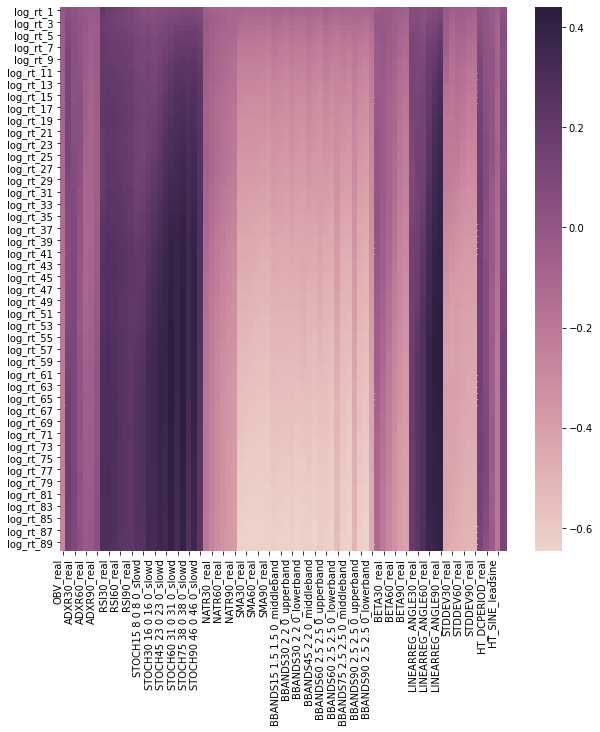

In [9]:
fig_name=target+'_Composite'
corr=utils.corr_plot(responses,tech,fig_name)

Before fitting the model, one need to tune the hyper parameters. The optimal hyper parameters will be saved thus one don't have to tune it every time as it is very time consuming. One can choose to re-calibrate the hyper parameters every 3 months or so.
<br>
<br>
The hyperparameters are chosen based on cross validation by a grid search. The first examples here uses randomforest. These are the three parameters I found most important to improve the cross validation scores.<br/>

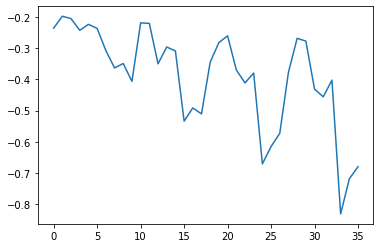

In [12]:
#tuning the hyper parameters
time_split = TimeSeriesSplit(n_splits=10)

rf_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('RFregressor',RandomForestRegressor())
    ])

rf_param_grid = {
    'RFregressor__max_depth': [1,2,3,5],
    'RFregressor__max_features': [1,3,10],
    'RFregressor__n_estimators': [10,100,200]
}

RF_searcher=GridSearchCV(estimator=rf_est, param_grid=rf_param_grid,
                                  scoring='r2', n_jobs=1, cv=time_split)

RF_searcher.fit(X.values,Y.values.ravel())

plt.plot(RF_searcher.cv_results_['mean_test_score'])

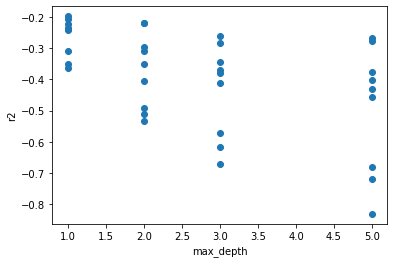

In [14]:
scaled_cv_results = RF_searcher.cv_results_
scaled_cv_accuracy = pd.DataFrame.from_dict(
    {'max_depth': [rec['RFregressor__max_depth'] for rec in scaled_cv_results['params']],
    'r2': scaled_cv_results['mean_test_score']})

plt.scatter(scaled_cv_accuracy.max_depth, scaled_cv_accuracy.r2, label="scaled_cv_r2")
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.show()

In [424]:
RF_searcher.best_params_

{'RFregressor__max_depth': 2,
 'RFregressor__max_features': 1,
 'RFregressor__n_estimators': 50}

In [15]:
rf = RandomForestRegressor(n_estimators=RF_searcher.best_params_['RFregressor__n_estimators'],
                           max_depth=RF_searcher.best_params_['RFregressor__max_depth'],
                           max_features=RF_searcher.best_params_['RFregressor__max_features'])
rf_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('RFregressor',rf)
    ])

cv_scores = cross_val_score(rf_est, X.values, Y.values.ravel(), cv=time_split,
                            scoring='r2')
cv_scores

array([-0.69748062, -0.09757359,  0.02594691, -0.02714295, -0.15928526,
       -0.21660362, -0.68649157, -0.04061189,  0.08203928, -0.24855519])

In [17]:
with open('./hypers/'+target+'_rf.json', 'w') as fp:
    json.dump(RF_searcher.best_params_, fp)

The second example is SVR. I have tryed a buntch of different models including LASSO, RIDGE,decision trees and neural networks. SVR and RandomForrest seems to be the best. Simpler models tends to underfitting while complicated ones such as neural networks tends to overfitting.<br/>
<br>
Among Random Forrest and SVR, though SVR yields slightly better out of sample cross validation scores, Random Forrest is more stable. And the predictions of Random Forrest are more linearly correlated to the real values despite of higher inflation of variances.SVR() gives random patterns sometimes.<br>

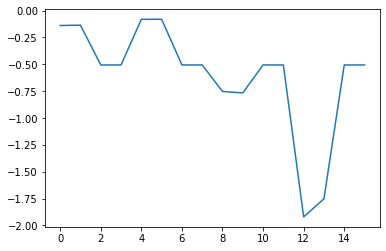

In [18]:
SVR_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('SVRregressor',SVR(gamma='scale',kernel='rbf'))
    ])
SVR_param_grid={'SVRregressor__C':[0.001,0.01,1,10],
               'SVRregressor__epsilon':[0.001,0.01,1,10]}
SVR_searcher=GridSearchCV(estimator=SVR_est, param_grid=SVR_param_grid,
                                  scoring='r2', n_jobs=1, cv=time_split)
SVR_searcher.fit(X.values,Y.values.ravel())

plt.plot(SVR_searcher.cv_results_['mean_test_score'])

In [20]:
SVR_searcher.best_params_

{'SVRregressor__C': 0.01, 'SVRregressor__epsilon': 0.01}

In [21]:
SVR_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('SVRregressor',SVR(gamma='scale',kernel='rbf',C=SVR_searcher.best_params_['SVRregressor__C'],
                        epsilon=SVR_searcher.best_params_['SVRregressor__epsilon']))
    ])

cv_scores = cross_val_score(SVR_est, X.values, Y.values.ravel(), cv=time_split,
                            scoring='r2')

with open('./hypers/'+target+'_svr.json', 'w') as fp:
    json.dump(SVR_searcher.best_params_, fp)

Now let's fit the model. I used 90 days as the shifting window to split the time series data into multiple blocks to train and cross validate it.(Based on the assumptions that the machine learning models will be re-calibrated every 90 days).<br>
<br>
For each block. Two types of figures are produced.<br>
<br>
First, the predicted investment return vs the real return. A good fit would expect that these two values align on a straight line or as close as possible. The plot is plotted for in-sample training data and out-of-sample test data seperately. For in-sample data, the model performance is fine. Yet for out-of sample, the variance can be big. But for most of cases, there are still a weak linear relationship between predicted and real returns for Random Forrest model. Thus at least we know the higher the predicted return ,the higher the chances one can get a positive return. <br>
<br>
Second, I used two measures to evaluate the model performance from an investment perspective. <br>
<br>
**1.precision**<br>
<br>
I borrowed this term from bio-stats because it reflects the performance of the strategy in an objective way. Back-testing is not the best tool because it only shows one trajectory and it is hard to attribute the returns. For example, some strategy can behave poorly yet still yields a handsome returns out of lacks. One can be holding the position and only buy in the year of 2017 when the crypto prices took off. It's easy to bias toward these strategies in back-testing. Yet these kind of strategy makes no sense in predicting forward.
<br/>
<br/>
**precison=True positive counts/Predicted positive counts**<br>
**=Count(real return is positive when predicted to buy)/Count(predicted to buy)**<br>
<br>
For a strategy to work, precision to have at least be greater than 0.5 to beat random guess. A good strategy should have a precision persistently greater than 0.7 or 0.8.<br>
<br>
**2.average return** <br>
<br>
precision doesn't take into acount the return. For investors, we want the average returns over time to be greater than our transaction costs to make a profit.<br>
<br>
**average retrun=Sum(return over one investment period)/Number of investment activities**
<br>
<br>
The precision and avg. return is plotted on the same plot.There two plots, first if for in-smaple data, second is for out-of-sample data.<br>
The x-axis is different thresholds, ranging from the lower bound of predicted return to the upper bound. It's assumed that only when the predicted return greater than the threshold, the buy decision will be made. Otherwise, the investor will just hold the cash. The left most bar suggests the results for always buying (the predicted return is always greater than it's lower bound). So this is equivalent to a long-crypto currency strategies. We can use the left most bar as a benchmark to the strategy performance. The strategy should be out-performing the benchmark. That's the cases we observed for this maichine learning strategy.(In worst cases, it is not deviating much while in good cases, it significantly beat the benchmark).<br>
<br>
The blue bar is indicating the average return while the orange bar showing the precision. The user can decide the optimal cut-off for threshold based on historical cross-validation testing on differnt batches of time series data.





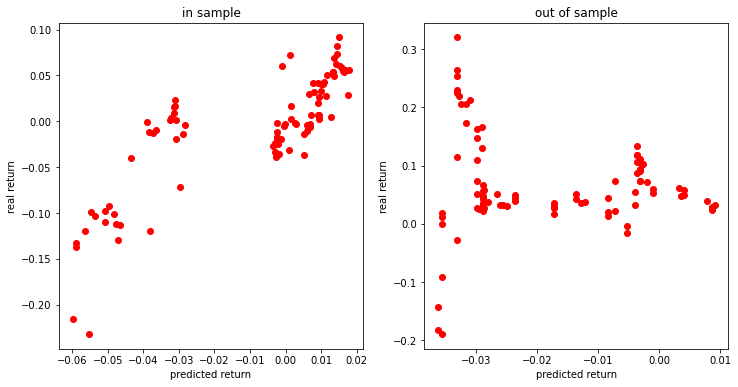

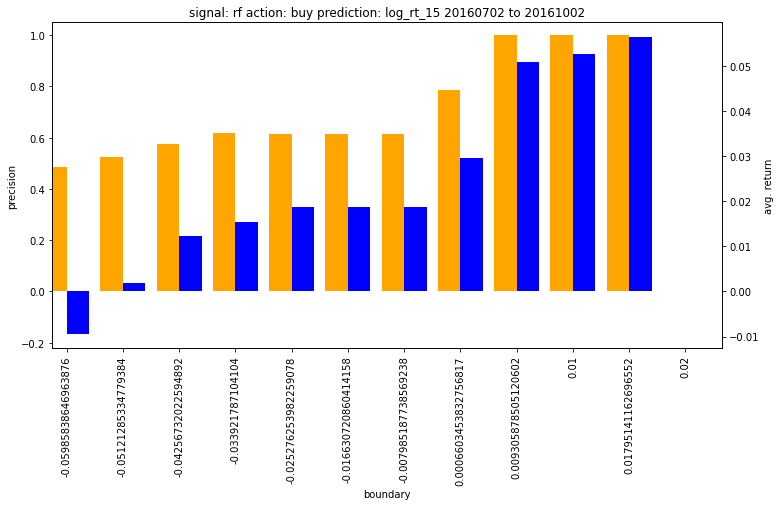

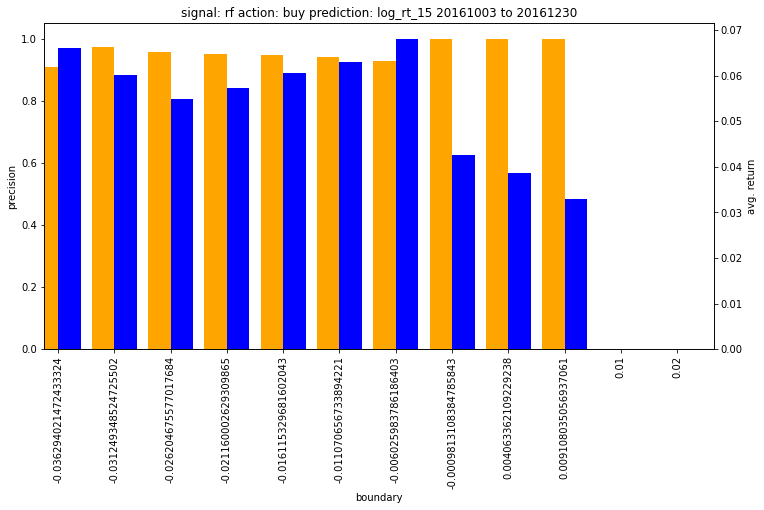

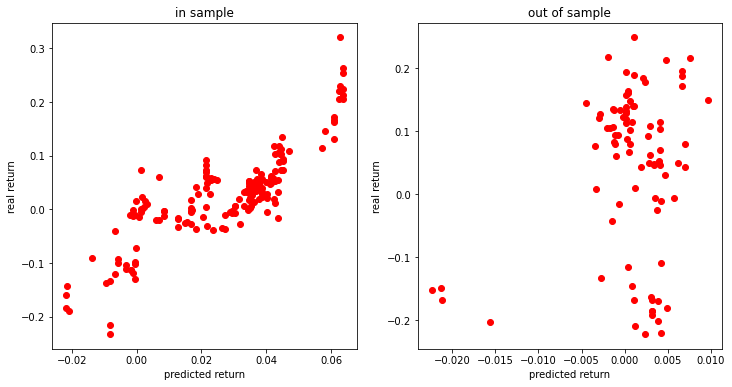

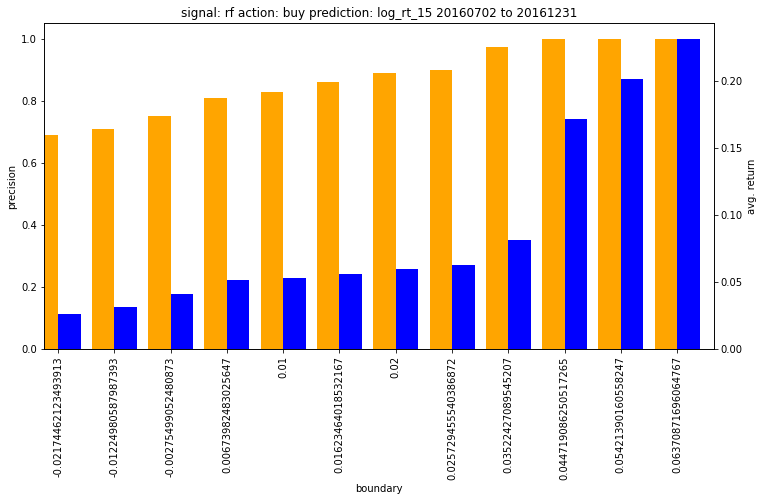

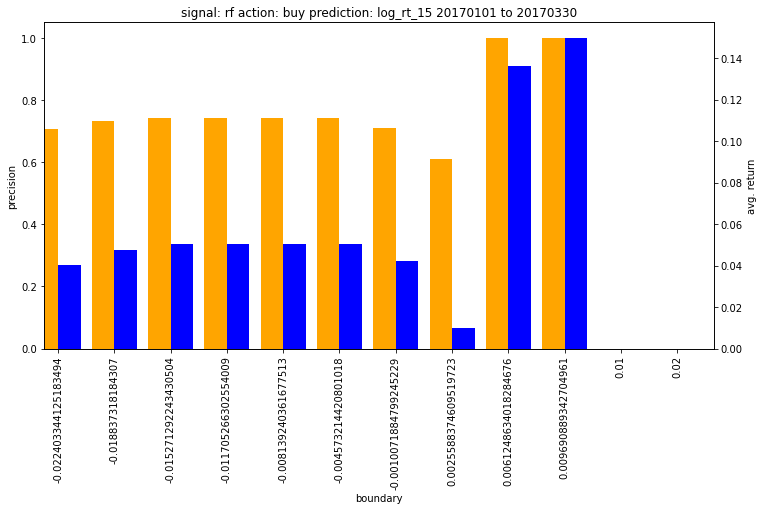

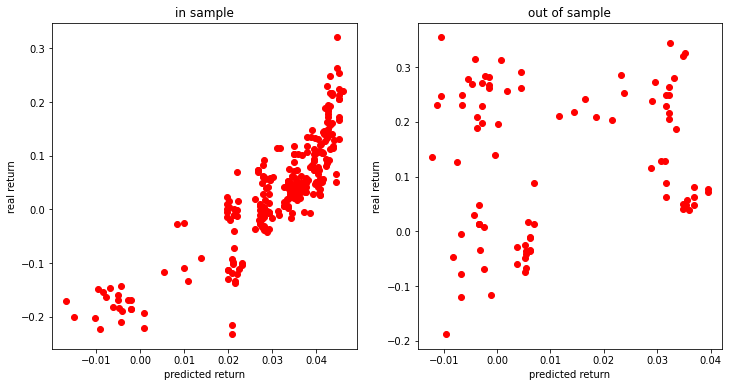

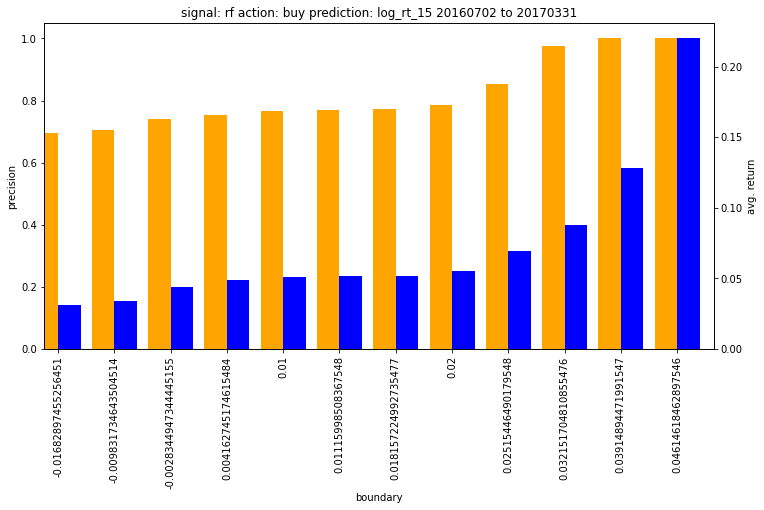

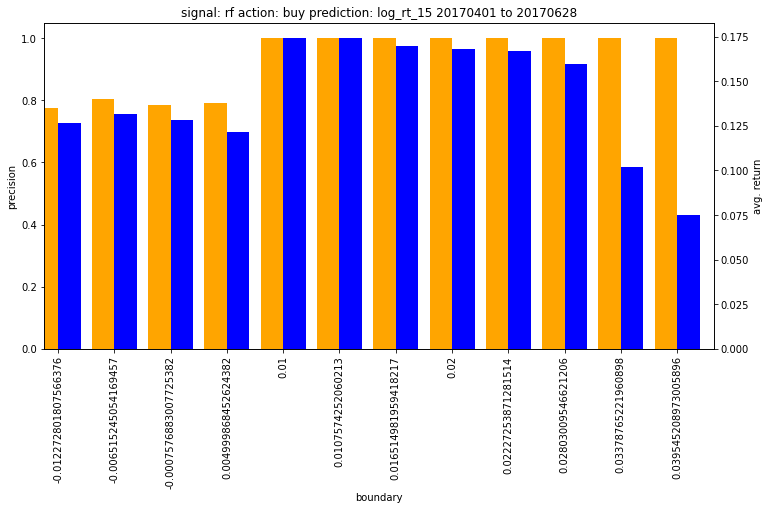

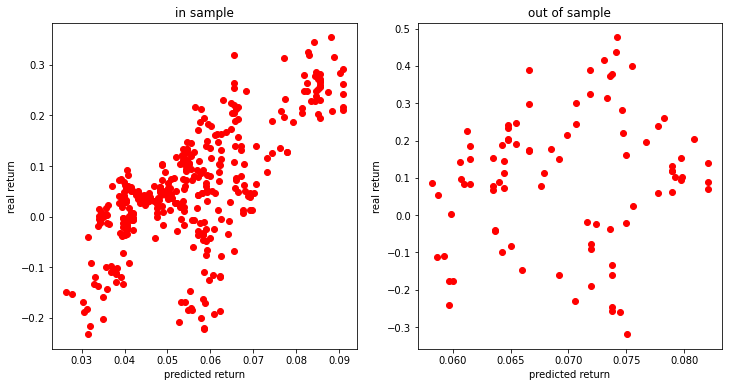

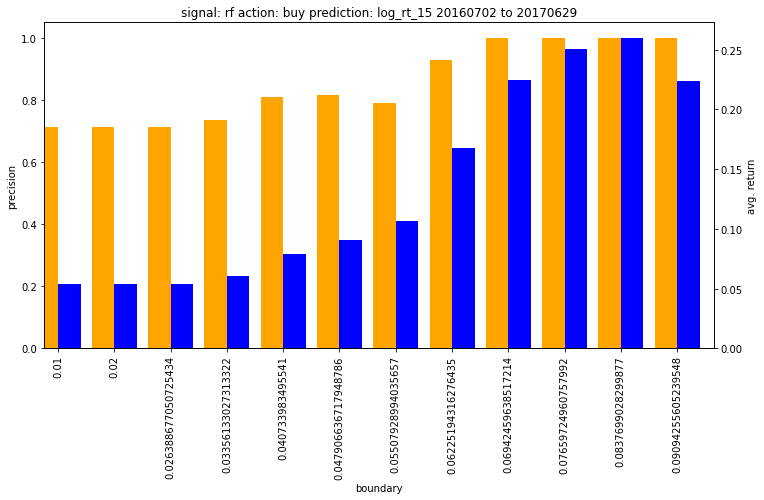

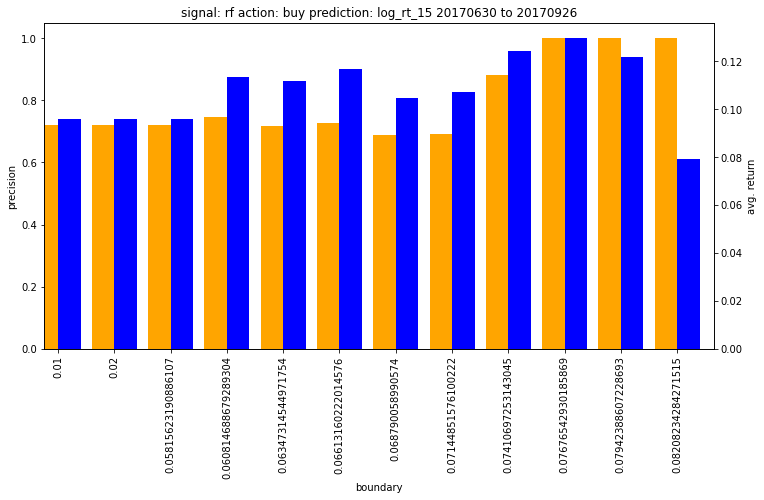

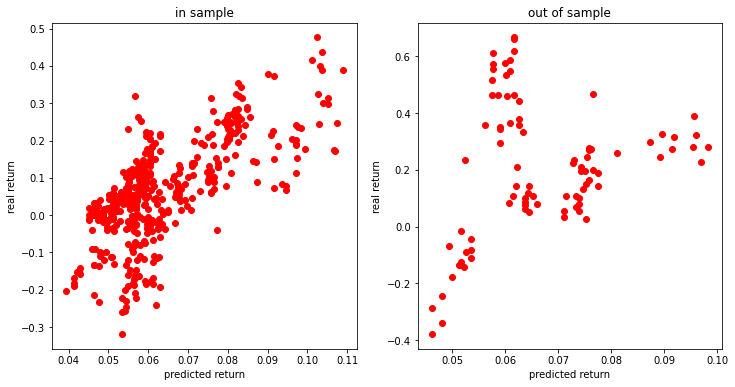

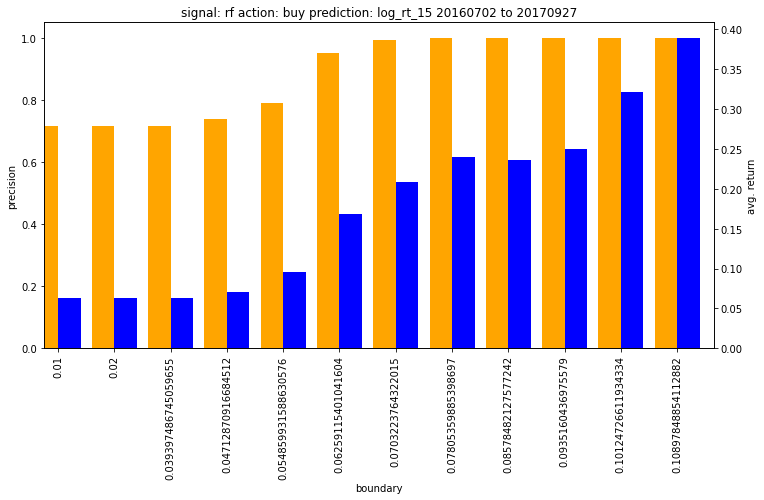

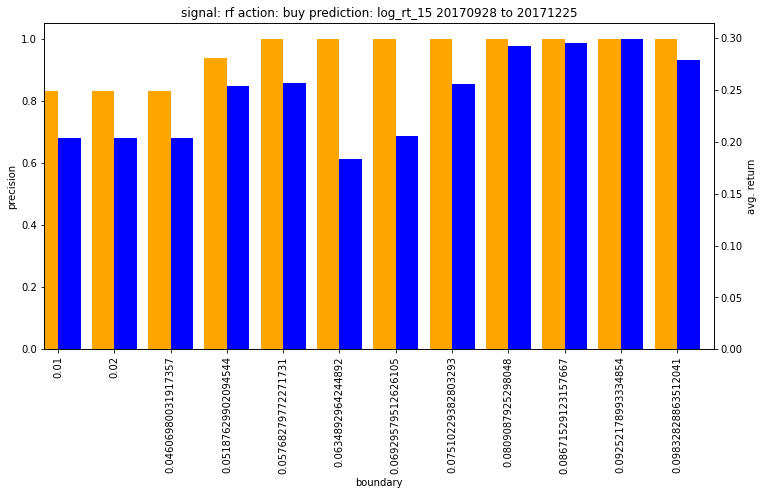

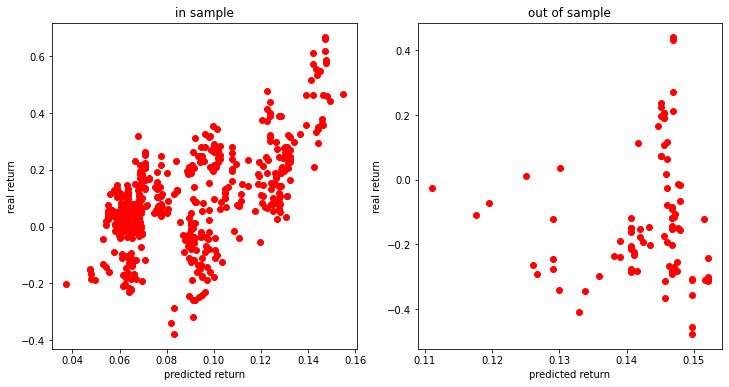

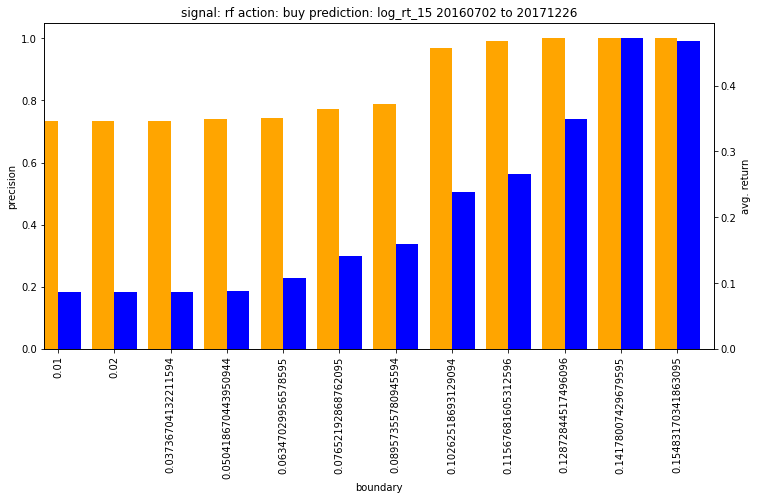

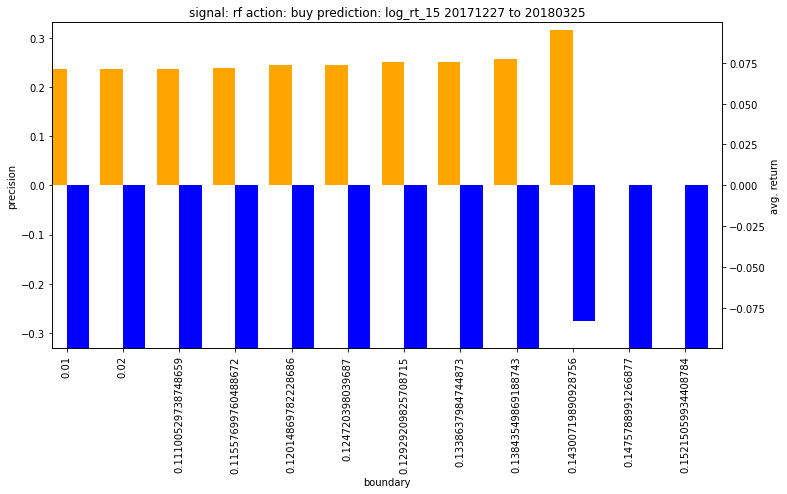

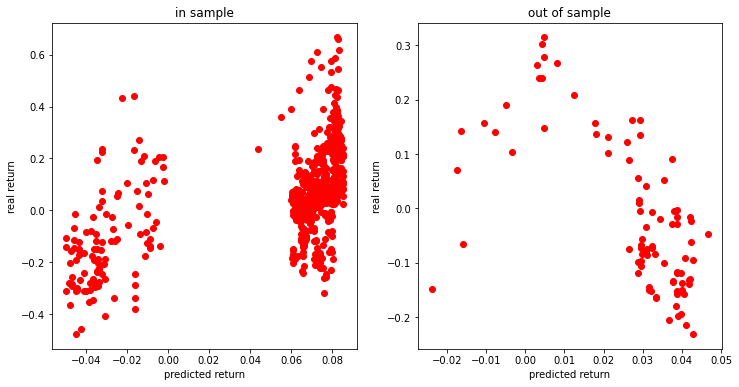

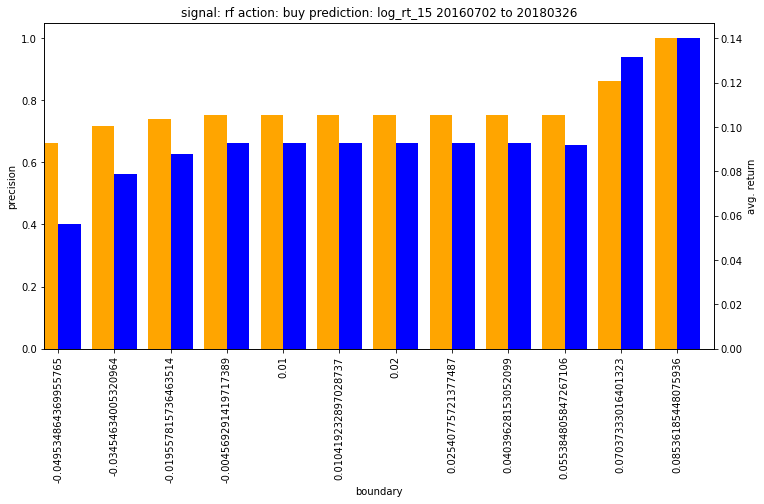

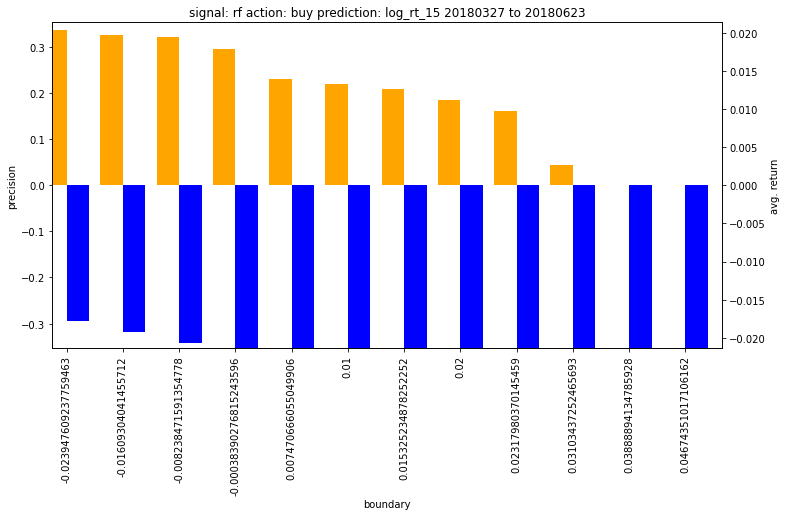

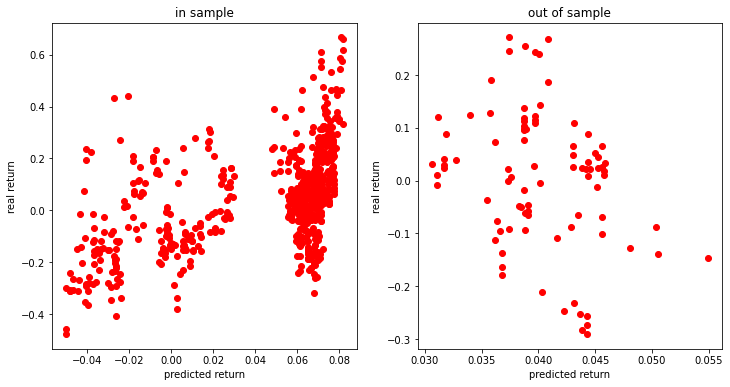

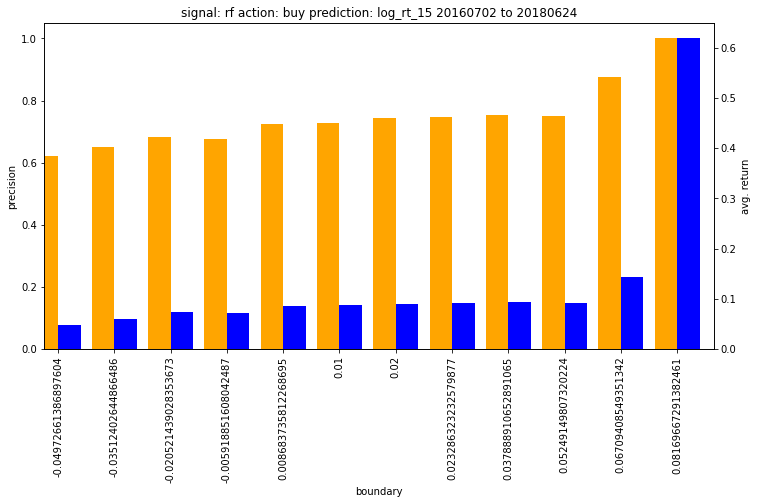

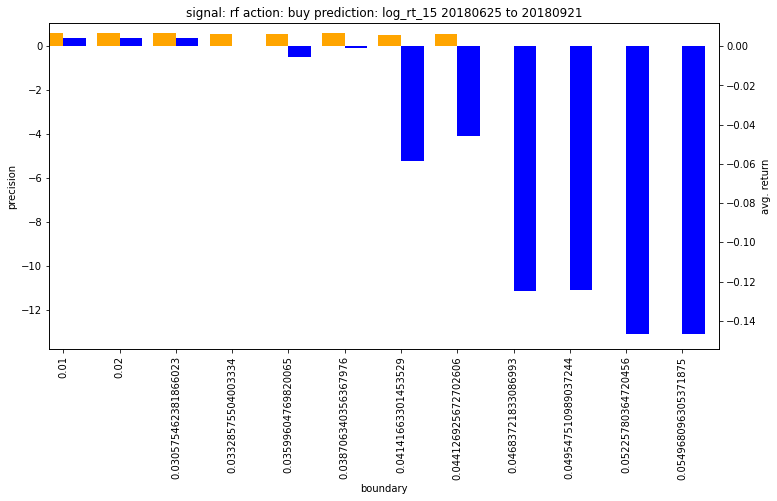

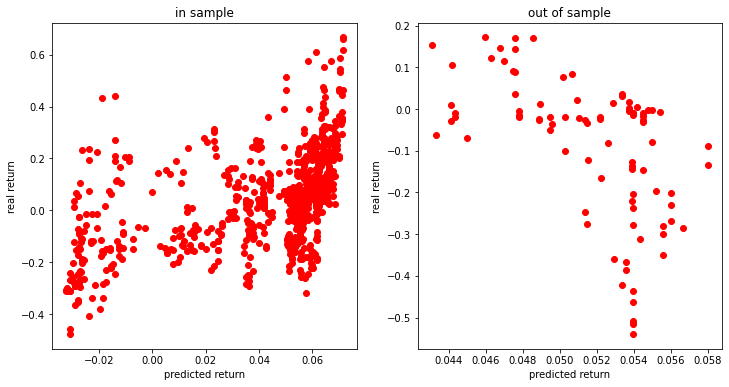

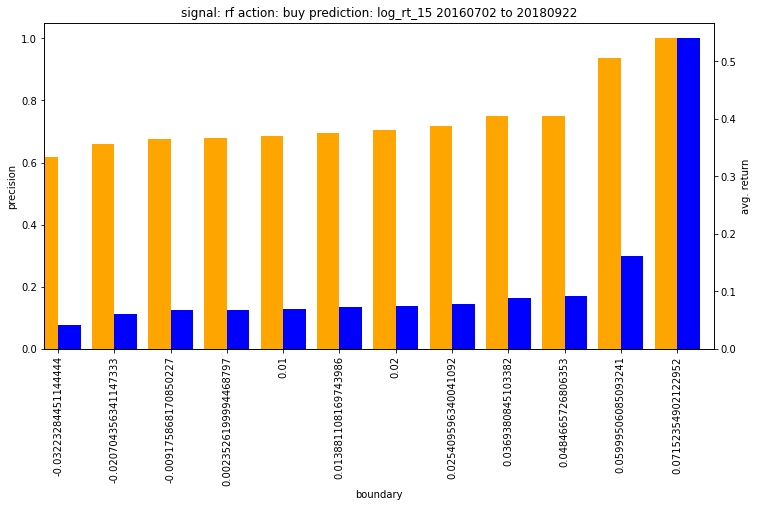

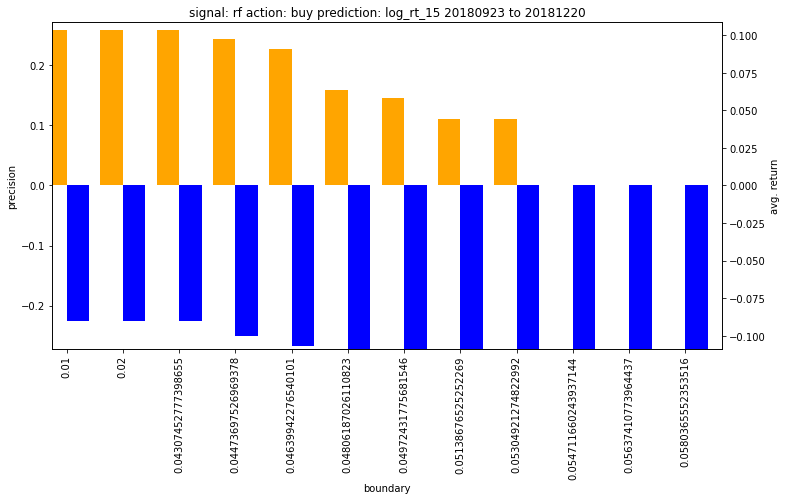

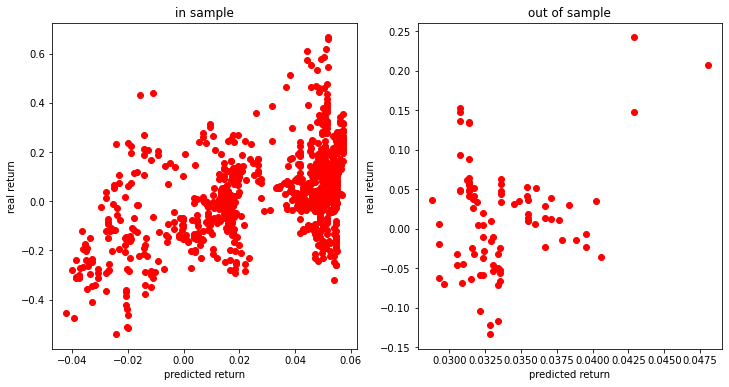

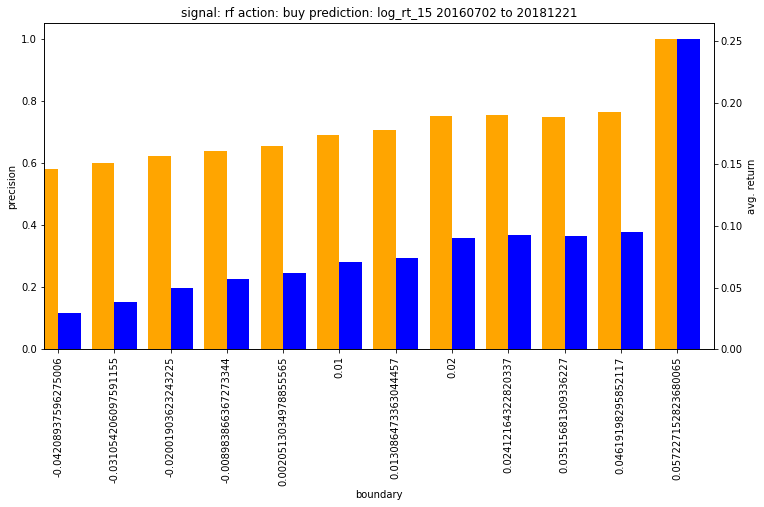

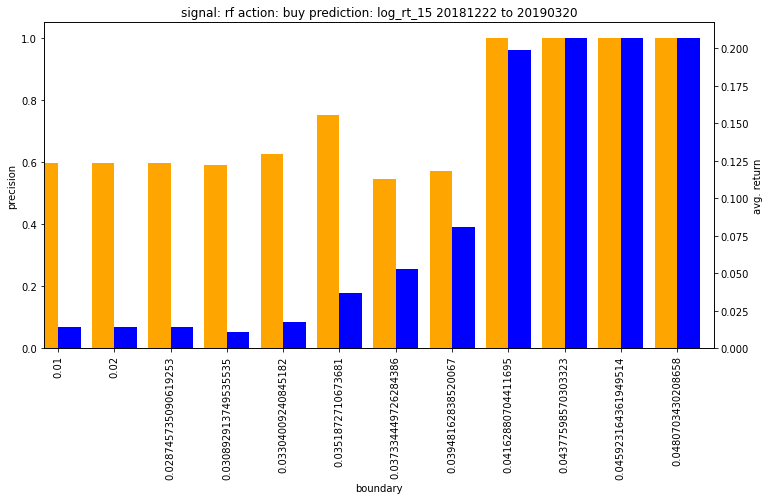

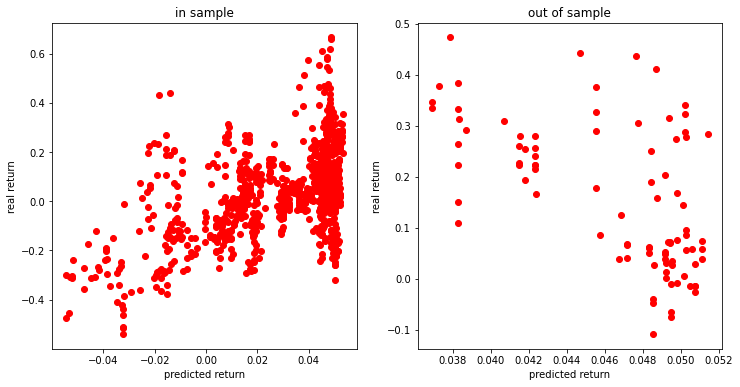

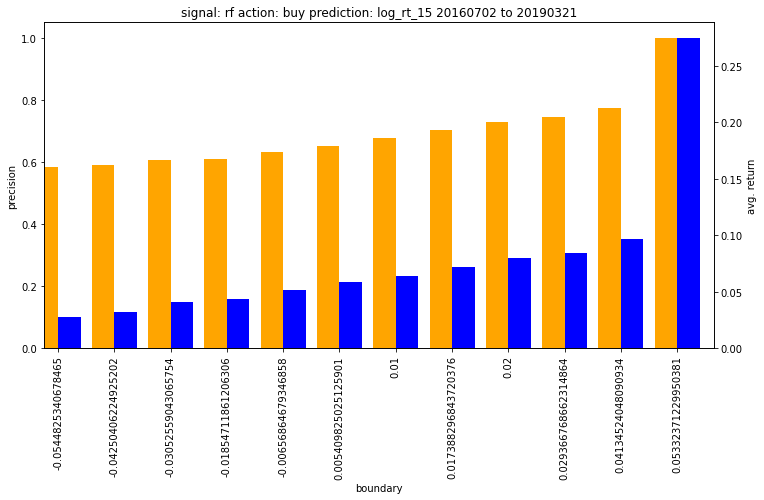

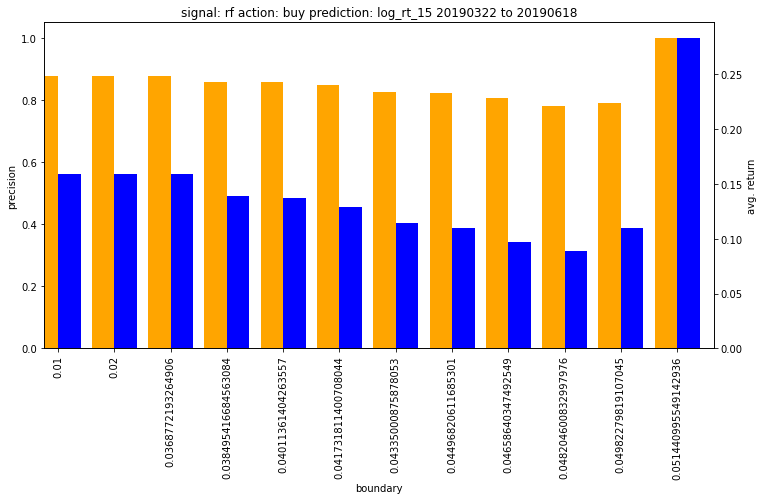

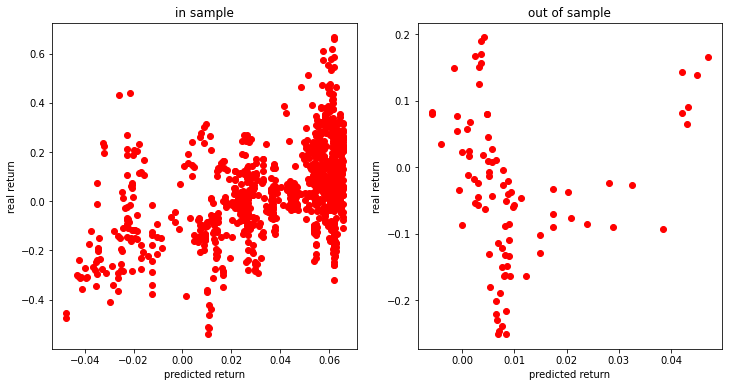

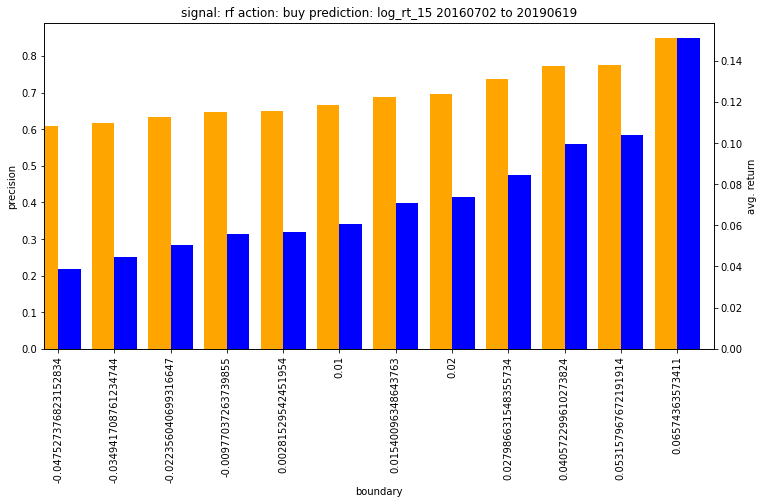

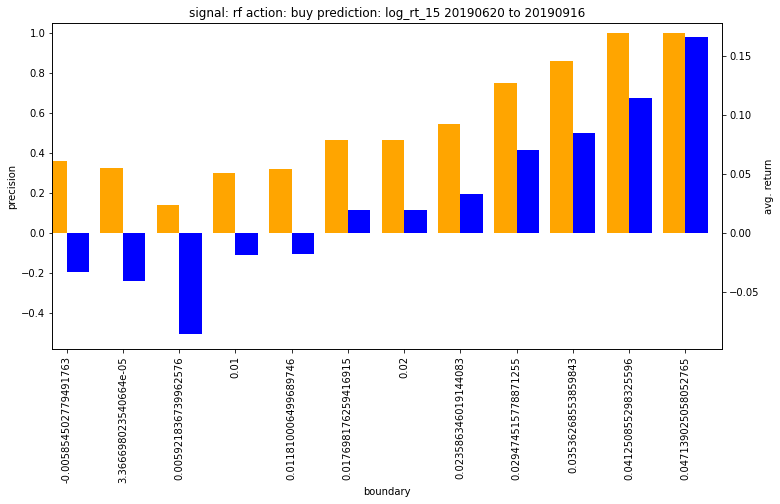

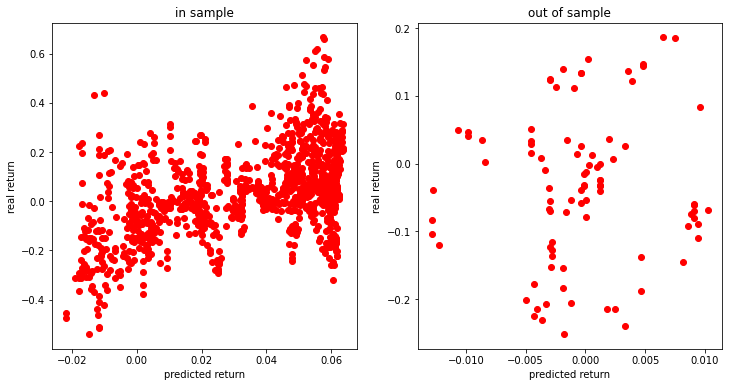

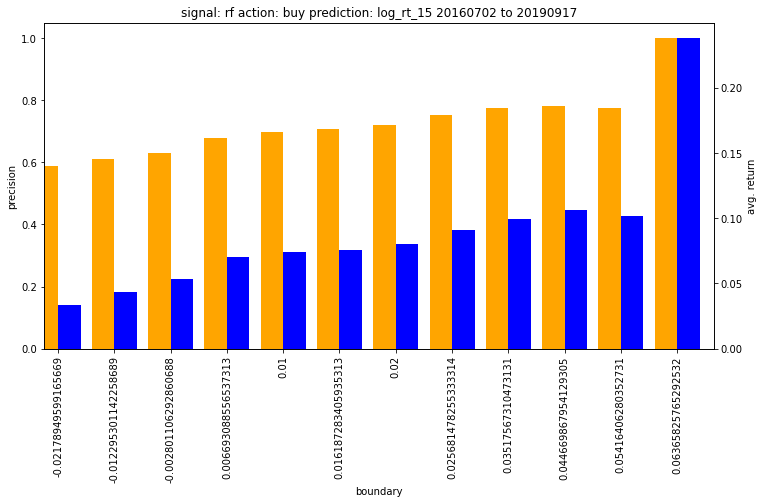

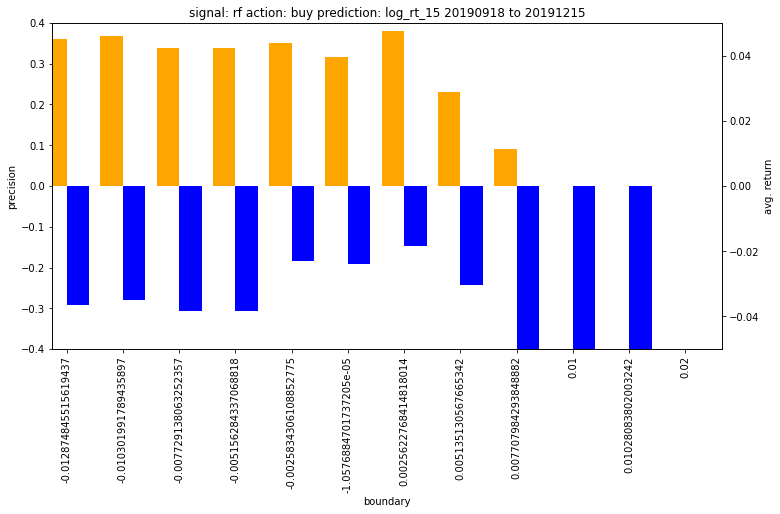

In [7]:
warnings.filterwarnings('ignore')
ml.fit_compo_index(X,Y,'rf',target)

In [8]:
plt.close('all')

SVR model performs a little worse from investment perspective despice better statistical scores. The user can compare and decide on their own. 

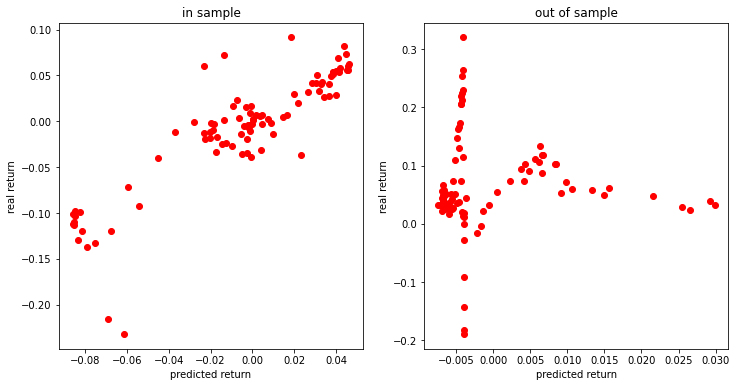

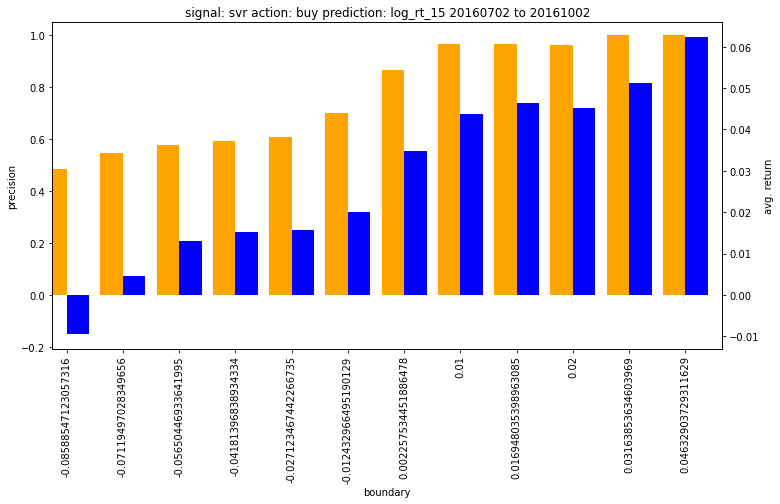

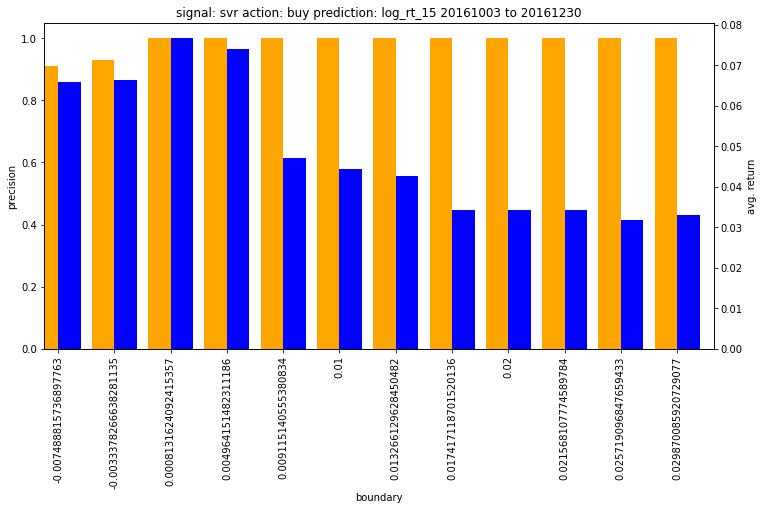

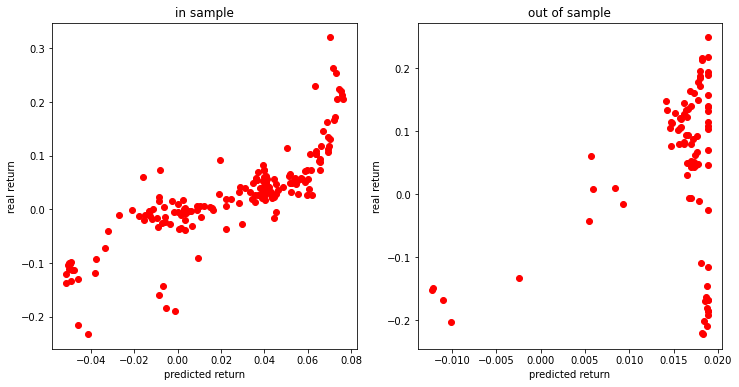

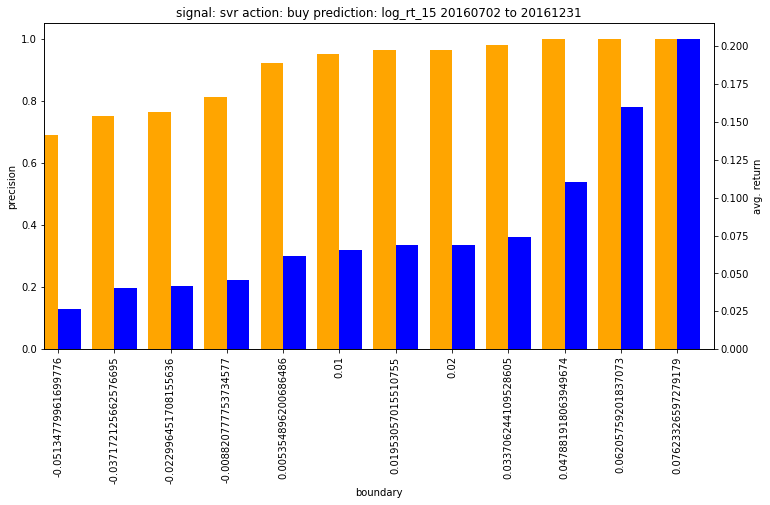

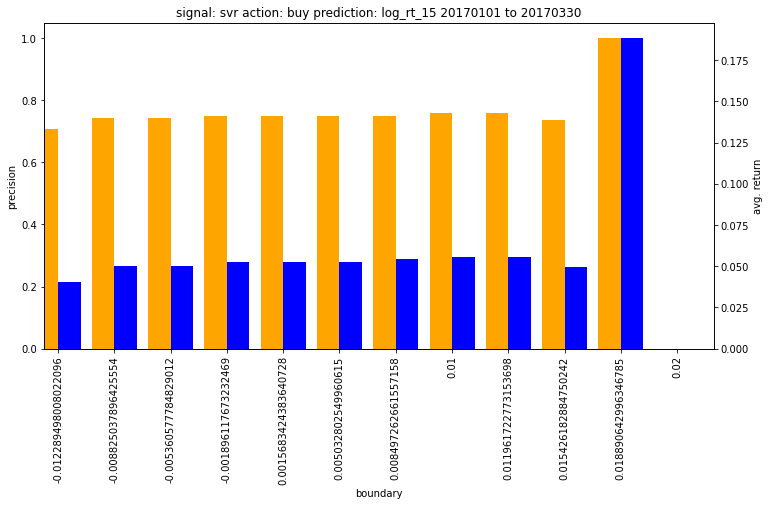

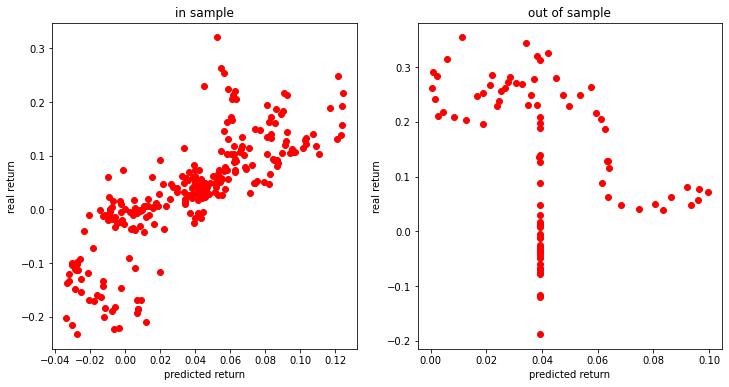

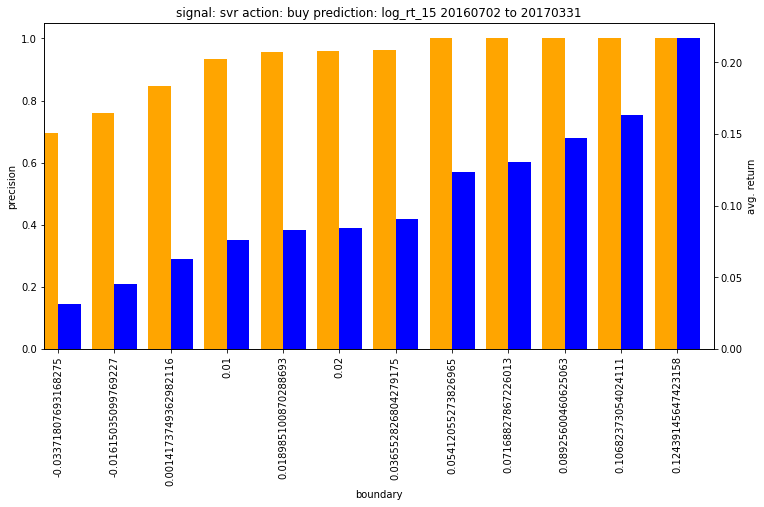

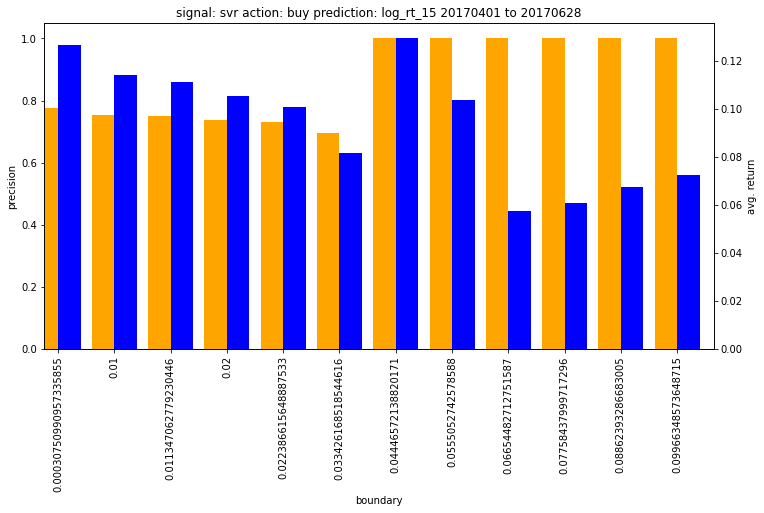

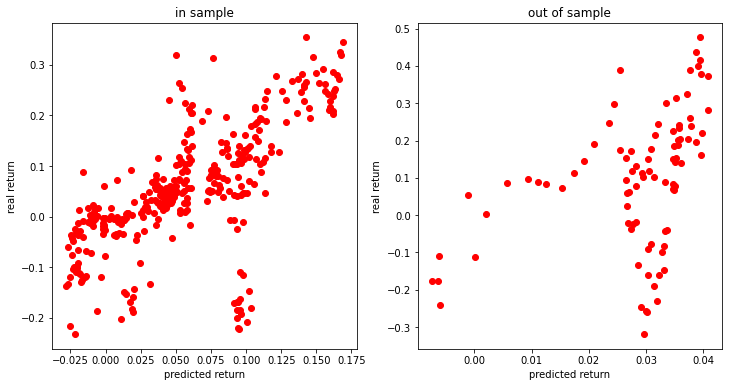

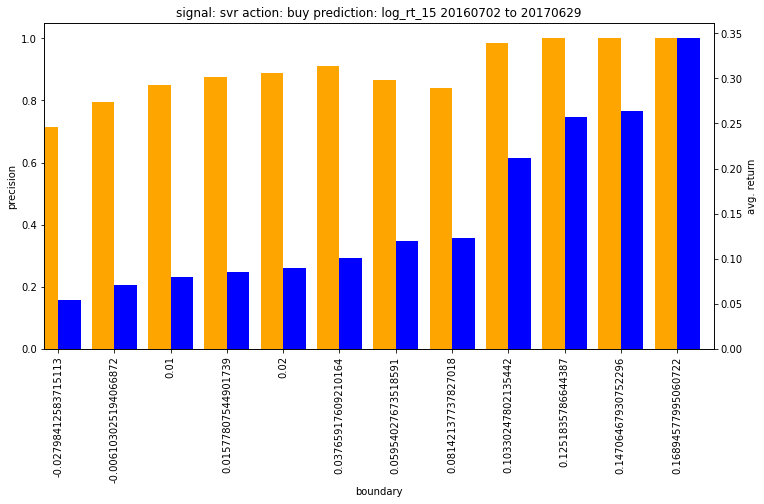

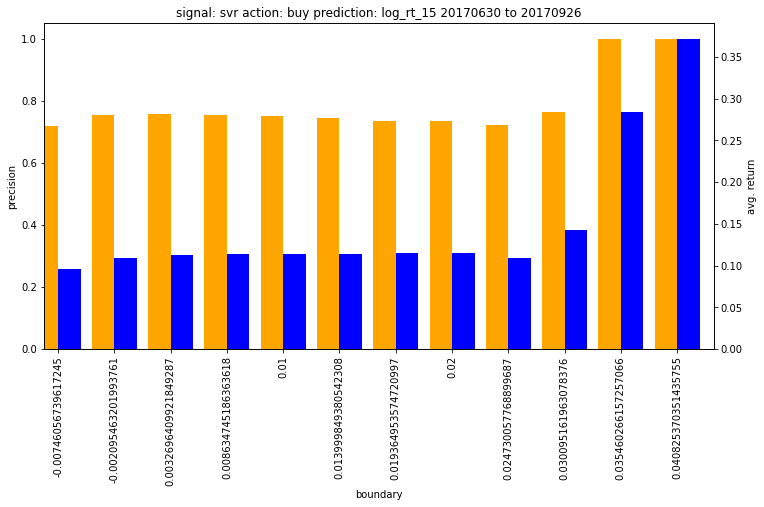

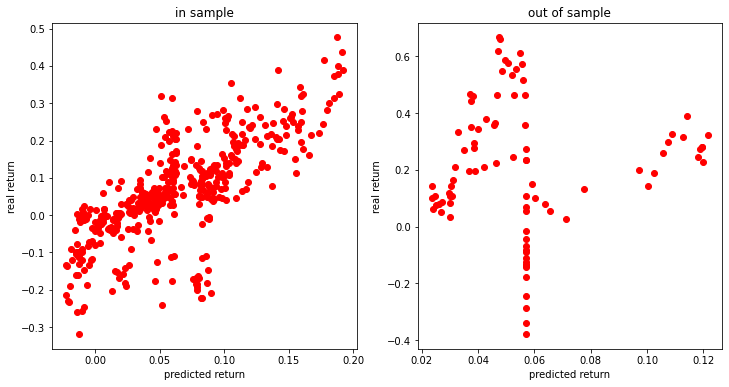

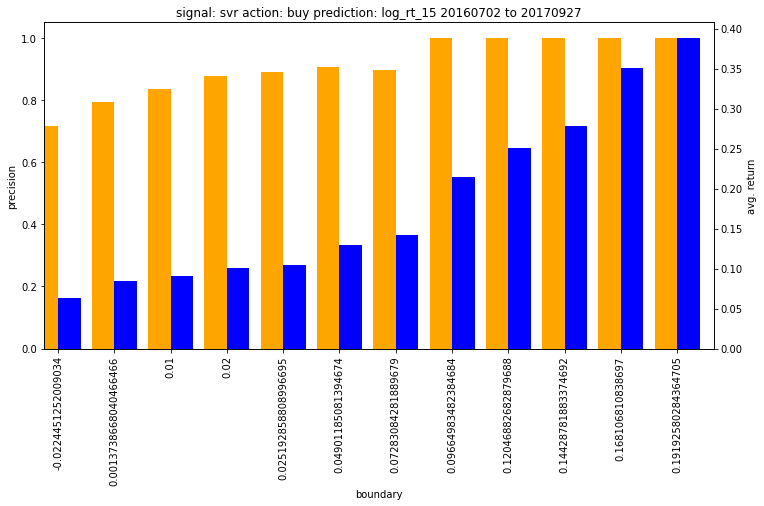

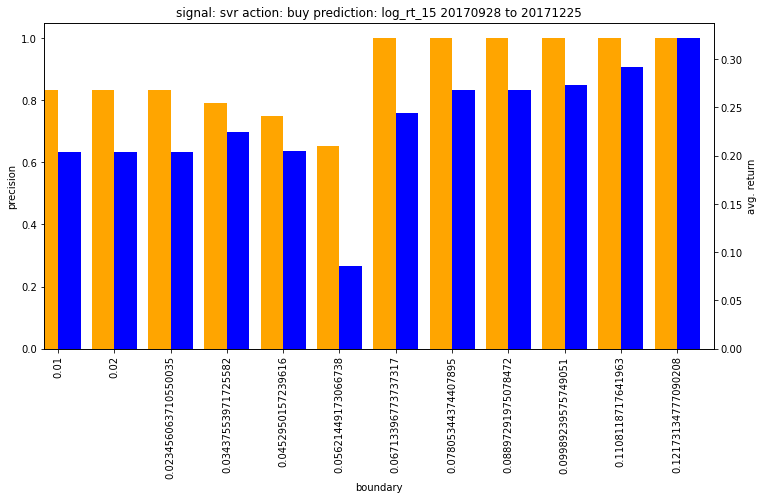

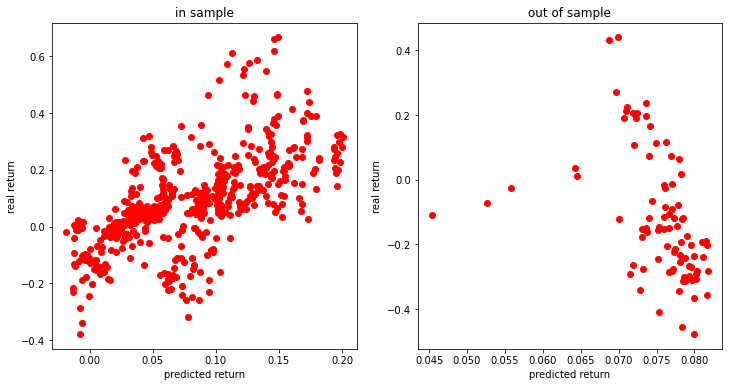

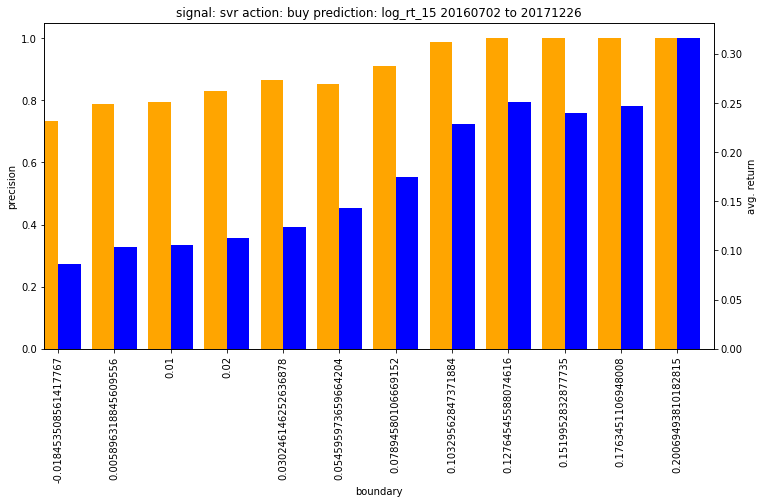

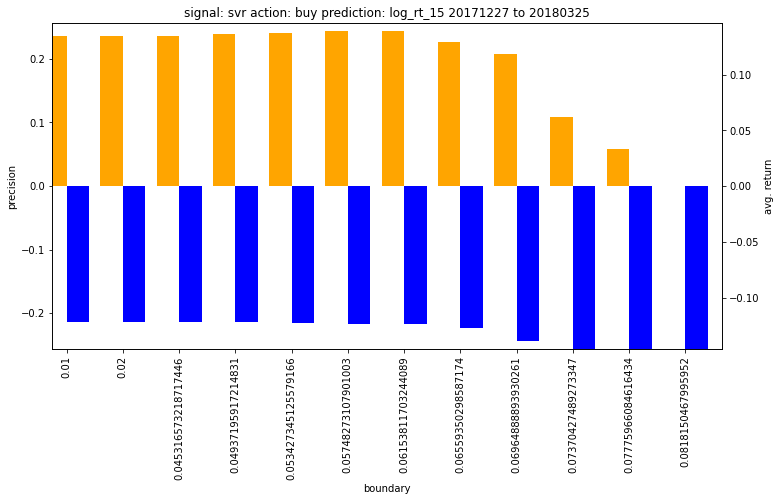

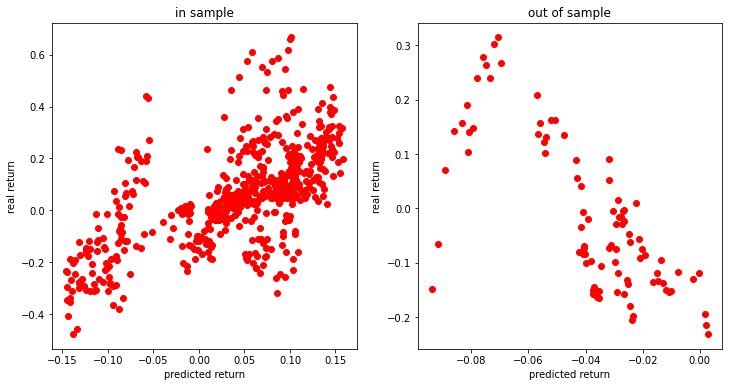

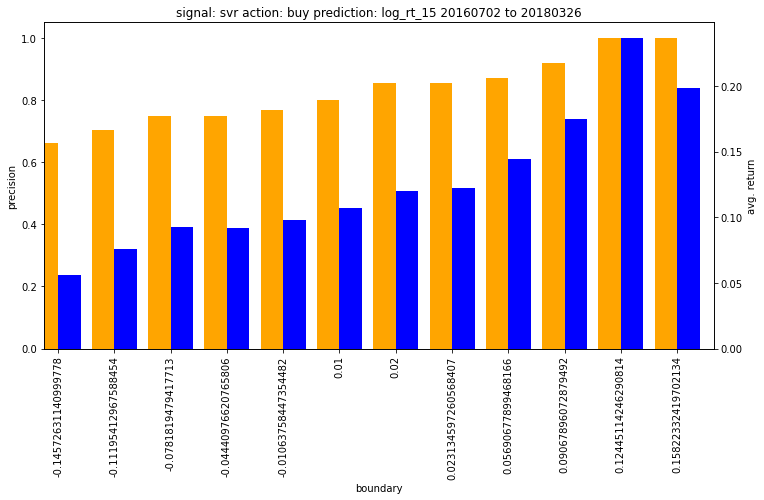

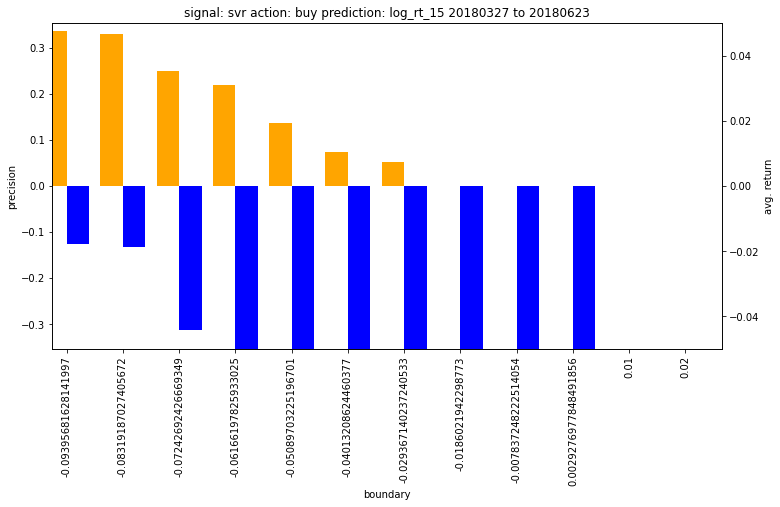

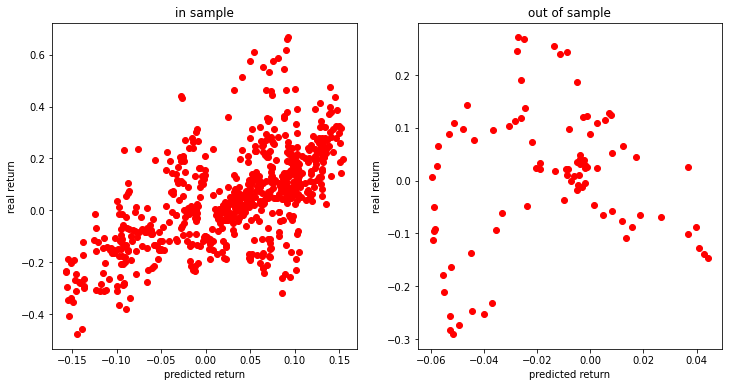

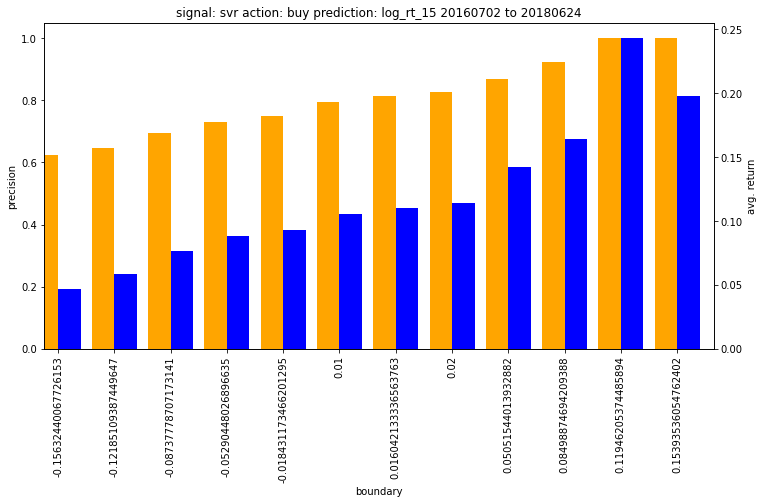

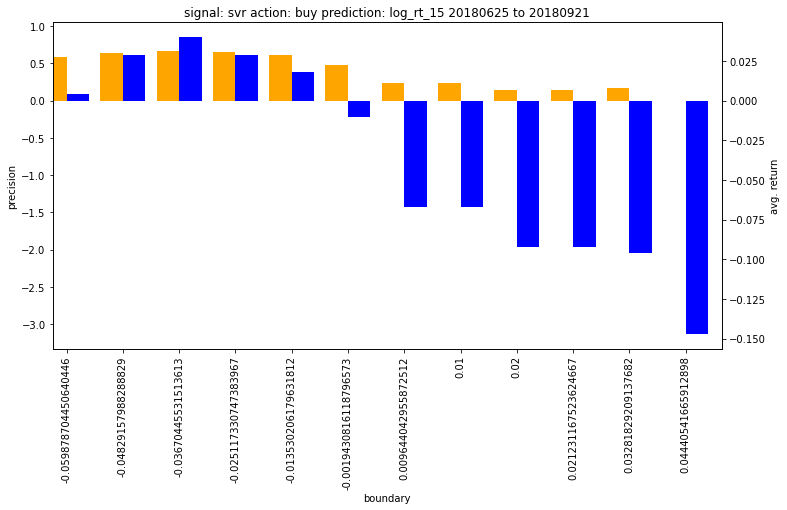

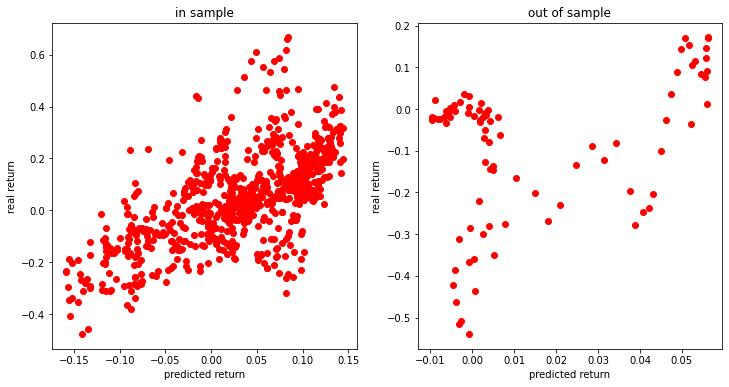

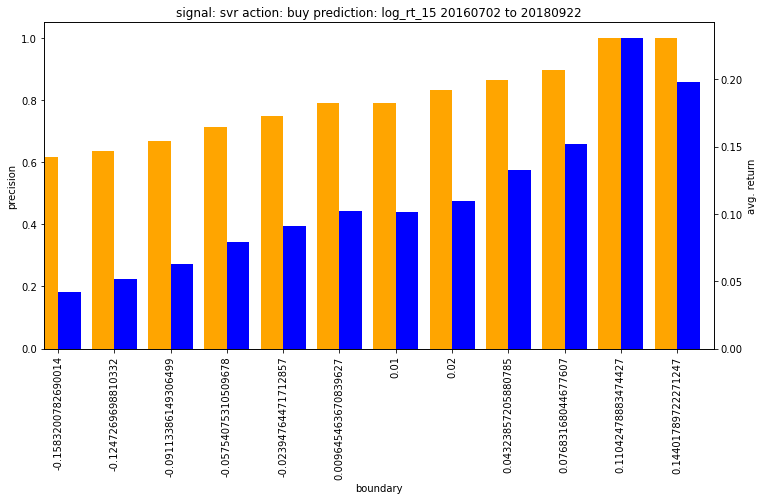

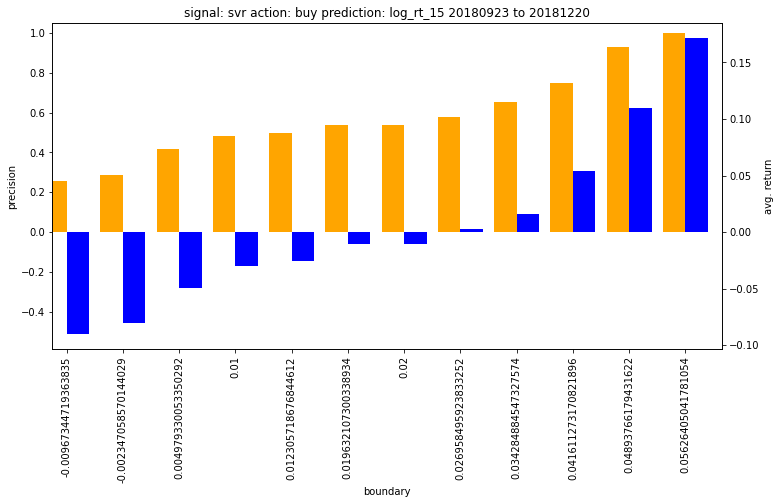

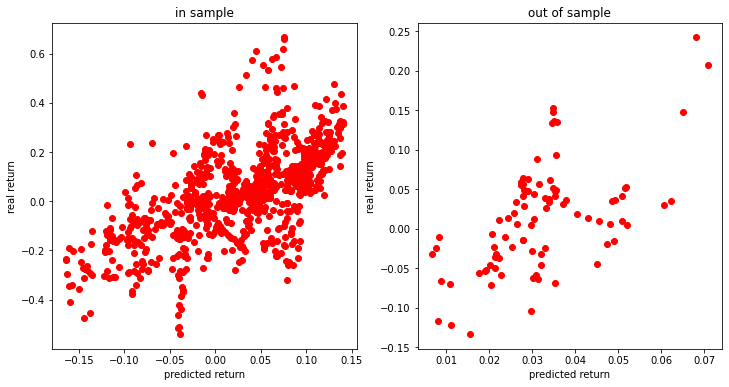

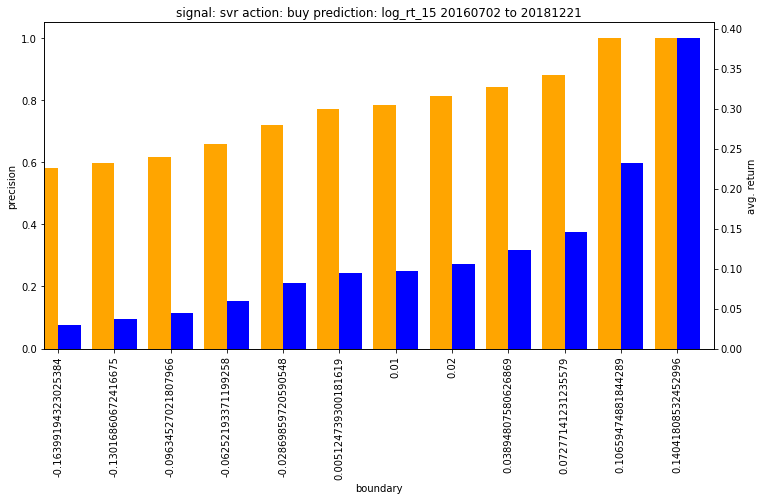

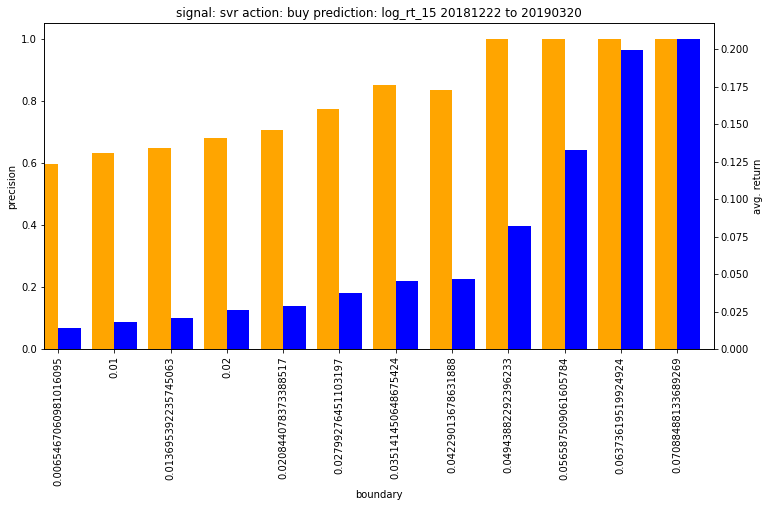

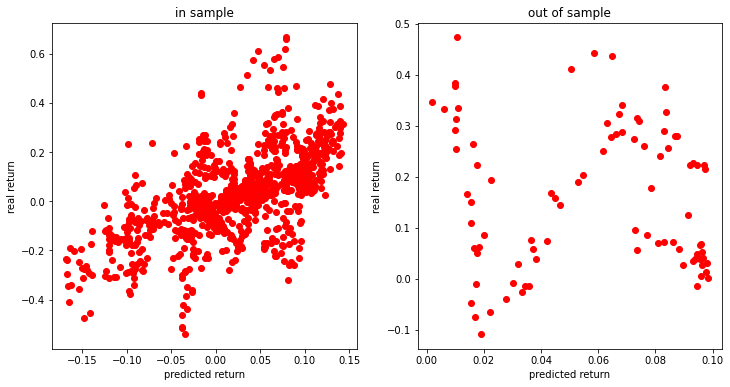

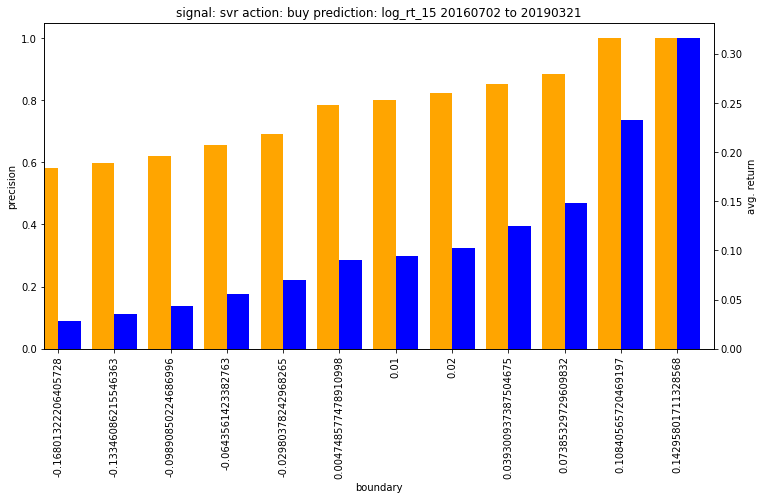

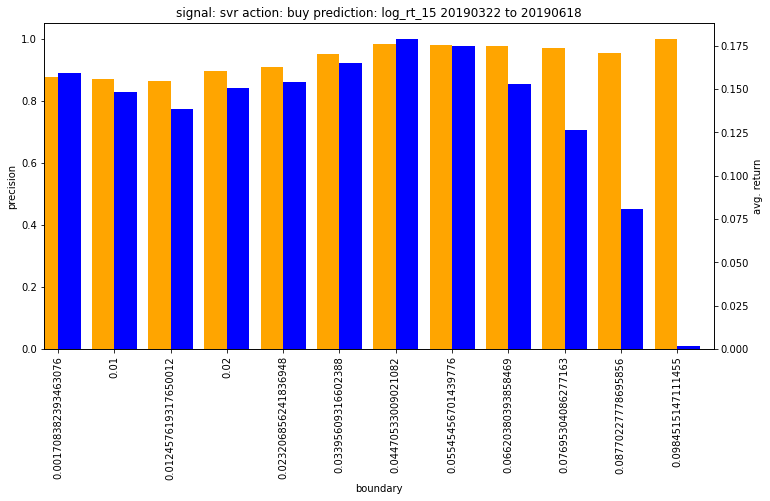

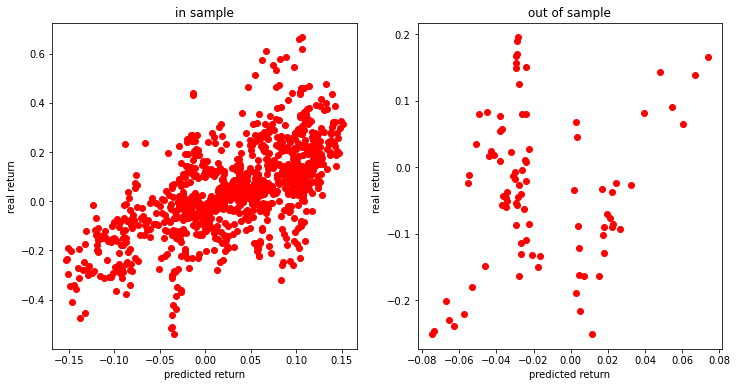

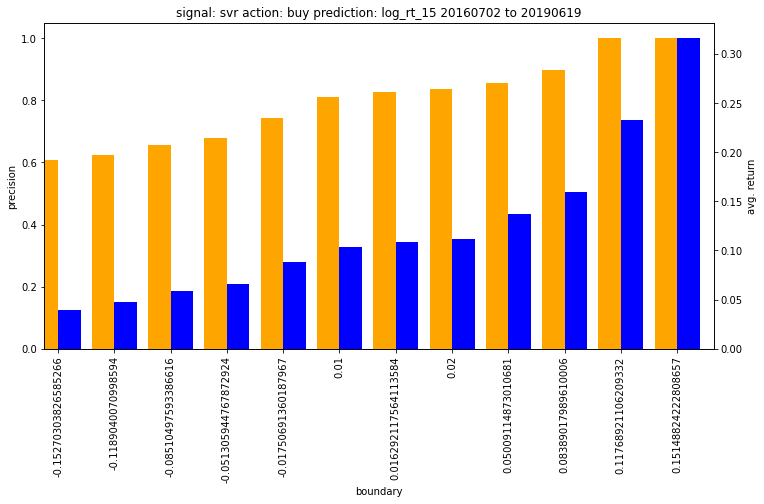

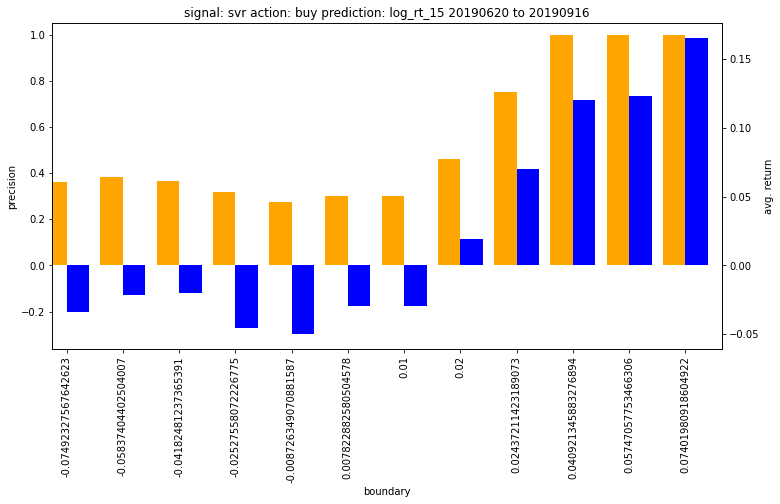

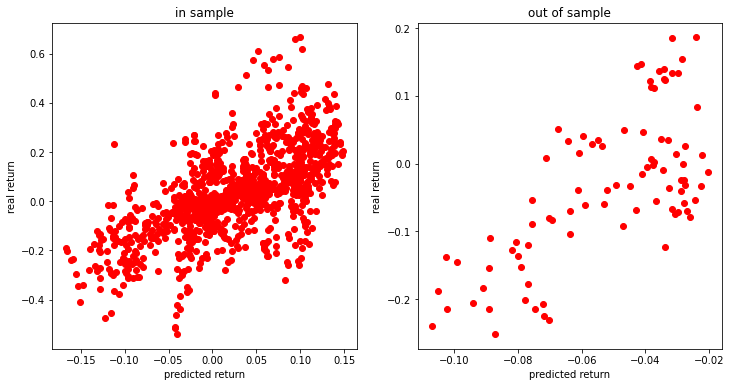

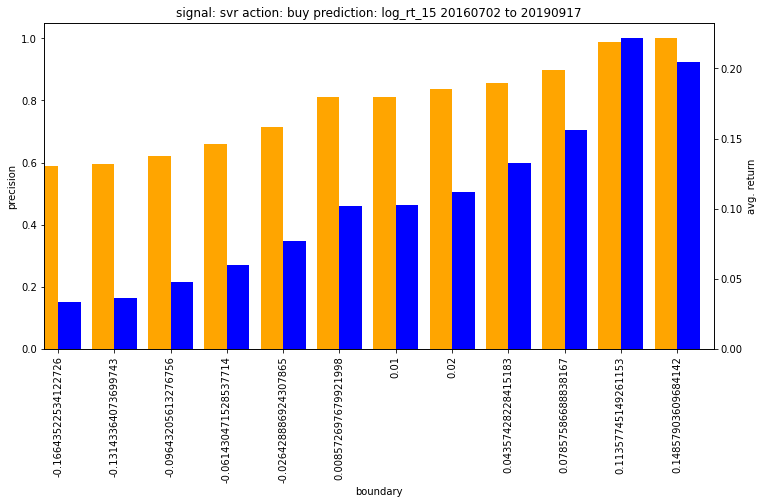

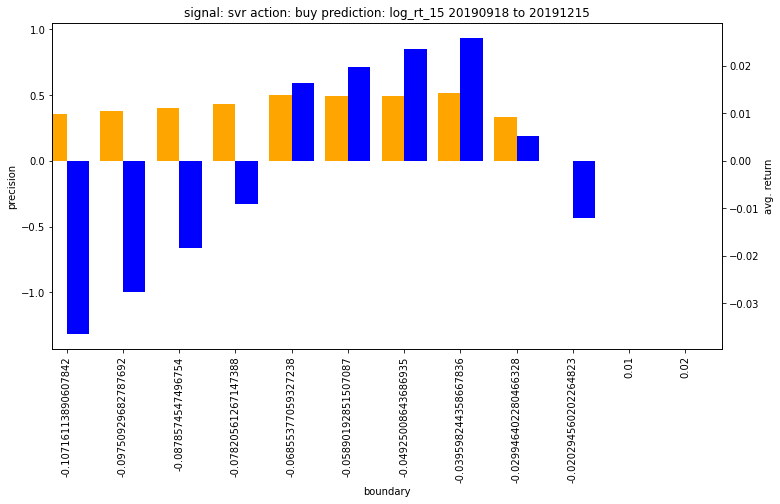

In [9]:
warnings.filterwarnings('ignore')
ml.fit_compo_index(X,Y,'svr',target)
